## Dataset Overview: bom.movie csv

This dataset, sourced from Box Office Mojo, contains information on movie titles and their corresponding box office performance. It includes release dates, studios, and gross earnings.

We will focus on cleaning and formatting this dataset to ensure it's usable for downstream analysis.

#### Cleaning Plan

In this section, I will:

- Load the raw `.csv.gz` dataset using pandas
- Inspect for missing values and inconsistent formats
- Convert columns to the correct data types (e.g., numeric, datetime)
- Standardize column names
- Drop or correct any unusable rows or columns
- Save the cleaned data to `data/cleaned/imdb_merged.csv`

### Load the Raw Data

We will load the compressed CSV file directly from `data/raw/` and preview the first few rows.

In [29]:
# Import standard libraries
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib as plt

# Load the raw compressed CSV file
bom_raw_path = 'data/raw/bom.movie_gross.csv.gz'

# Read it using pandas
bom_df = pd.read_csv(bom_raw_path)

# Preview the data
bom_df.head(100)


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/bom.movie_gross.csv.gz'

#### Detect Missing Data
Before we clean, we inspect the dataset for missing values to understand the extent and location of the gaps. This helps us decide the appropriate handling strategy.

In [15]:
# View basic info
bom_df.info()

# Count of missing values per column
bom_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1906 entries, 0 to 1905
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   title            1906 non-null   object 
 1   studio           1904 non-null   object 
 2   domestic_gross   1895 non-null   float64
 3   foreign_gross    1297 non-null   float64
 4   start_year       1906 non-null   int64  
 5   movie_id         1906 non-null   object 
 6   primary_title    1906 non-null   object 
 7   original_title   1906 non-null   object 
 8   runtime_minutes  1903 non-null   float64
 9   genres           1906 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 149.0+ KB


title                0
studio               2
domestic_gross      11
foreign_gross      609
start_year           0
movie_id             0
primary_title        0
original_title       0
runtime_minutes      3
genres               0
dtype: int64

In [20]:
import os

os.listdir('data/raw')

['im.db', 'im.zip']

We calculate the percentage of missing values for each column. Columns with a high percentage of missing data may be dropped, while those with fewer missing values may be imputed or cleaned case-by-case.

In [ ]:
# Percentage of missing values per column
(bom_df.isnull().sum() / len(bom_df) * 100).sort_values(ascending=False)

foreign_gross     39.858282
domestic_gross     0.826690
studio             0.147623
title              0.000000
year               0.000000
dtype: float64

#### Handling Missing Values

We found that nearly 40% of `foreign_gross` values are missing. This is expected since not all movies are released internationally. We'll treat these as 0. A similar logic is applied to `domestic_gross`. `studio` has a very small percentage of missing data, so we'll fill with `'Unknown'`.

In [ ]:
# Fill missing values
# bom_df['foreign_gross'] = bom_df['foreign_gross'].replace('[\$,]', '', regex=True)
# bom_df['domestic_gross'] = bom_df['domestic_gross'].replace('[\$,]', '', regex=True)

# Convert to numeric and fill missing as 0
bom_df['foreign_gross'] = pd.to_numeric(bom_df['foreign_gross'], errors='coerce').fillna(0)
bom_df['domestic_gross'] = pd.to_numeric(bom_df['domestic_gross'], errors='coerce').fillna(0)

# Fill missing studios with 'Unknown'
bom_df['studio'] = bom_df['studio'].fillna('Unknown')


Let's do a final check:

In [ ]:
bom_df.isnull().sum()
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000.0,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000.0,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000.0,2010
3,Inception,WB,292600000.0,535700000.0,2010
4,Shrek Forever After,P/DW,238700000.0,513900000.0,2010


### Purpose of Using IMDB Here

Our goal is to analyze **studio performance** and **revenue distribution** between **domestic and international markets.**

To ensure accurate matching between:
- `bom.movie_gross` (which includes studio, domestic, foreign gross)
- and cleaned financials from TN or BOM

…we use `movie_basics` to:
- Validate movie titles
- Confirm accurate release years
- Ensure that duplicated or foreign release titles don’t interfere with our regional revenue analysis

Let's first view the tables in the database:


In [18]:
import zipfile

# Path to the ZIP file
zip_path = 'data/raw/im.db.zip'
# Destination path for extraction
extract_to = 'data/raw/'

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction complete. Check 'data/raw/im.db'")


FileNotFoundError: [Errno 2] No such file or directory: 'data/raw/im.db.zip'

In [ ]:
# Connect to the unzipped database
conn = sqlite3.connect('data/raw/im.db')

# List all tables
tables = pd.read_sql("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


#### Step 1: Load and Preview `movie_basics` Table

We start by exploring the `movie_basics` table to understand its structure and contents. This helps us identify:
- Which columns are useful for our regional revenue + studio analysis
- Whether titles and years are clean and complete


In [ ]:
# Read the movie_basics table
movie_basics = pd.read_sql("SELECT * FROM movie_basics", conn)

# Preview the first few rows
movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


#### Step 2: Understand Column Data Types and Null Values

This step helps us detect missing or malformed entries in `movie_basics` before we begin any cleaning or merging.

In [ ]:
# General information about the dataset
movie_basics.info()

# Check for missing values
movie_basics.isnull().mean().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


runtime_minutes    0.217176
genres             0.037005
original_title     0.000144
movie_id           0.000000
primary_title      0.000000
start_year         0.000000
dtype: float64

#### Dataset Summary: `movie_basics`

This dataset contains metadata on 146,144 movies extracted from IMDB. The columns available include:

| Column            | Description                                     |
|-------------------|-------------------------------------------------|
| `movie_id`        | Unique IMDB movie identifier (`tconst`)         |
| `primary_title`   | Main title of the movie                         |
| `original_title`  | Title in original language                      |
| `start_year`      | Year the title was released                     |
| `runtime_minutes` | Duration of the movie in minutes                |
| `genres`          | Genre classification (comma-separated)          |

#####  Rows: `146,144`  
#####  Missing Values:
- `runtime_minutes` is missing in ~21.7% of rows
- `genres` is missing in ~3.7% of rows
- `original_title` is missing in only ~0.01% of rows

We observe that both `primary_title` and `start_year` are complete and suitable for use in merges with external datasets like `bom.movie_gross.csv.gz`.


#### Why Use `movie_basics`?

For our **studio + revenue region analysis**, `movie_basics` serves as:

- A validation tool to verify titles and release years across datasets.
- A secondary source of information on genres and runtimes (if needed).
- A linking bridge using `primary_title` + `start_year` for merging with BOM or budget data.

While not focused on financials itself, it's essential for data integration and contextual enrichment.


#### Cleaning for Merge

To prepare for accurate merging between Box Office Mojo (`bom.movie_gross.csv.gz`) and IMDB’s `movie_basics`, we standardized column names, normalized movie titles by lowercasing and stripping whitespace, and dropped missing values in merge-critical fields. 

This allowed us to join the datasets using `title + year` (renamed to `start_year`), creating a bridge between gross revenue data and IMDB metadata (e.g., genres, runtimes).


In [ ]:
# Clean BOM dataset
bom_df_clean = bom_df.copy()

# Standardize column names
bom_df_clean.rename(columns={'year': 'start_year'}, inplace=True)

# Lowercase and strip titles
bom_df_clean['title_clean'] = bom_df_clean['title'].str.lower().str.strip()

# Drop rows with missing titles or years
bom_df_clean.dropna(subset=['title_clean', 'start_year'], inplace=True)
bom_df_clean['start_year'] = bom_df_clean['start_year'].astype(int)

# Clean IMDB movie_basics dataset
mb_clean = movie_basics.copy()

# Lowercase and strip titles
mb_clean['title_clean'] = mb_clean['primary_title'].str.lower().str.strip()

# Drop rows with missing titles or years
mb_clean.dropna(subset=['title_clean', 'start_year'], inplace=True)


### Merging the Datasets

In [ ]:
# Step 1: Keep only essential columns post-merge
merged_df = merged_df[[
    'title', 'studio', 'domestic_gross', 'foreign_gross', 'start_year',
    'movie_id', 'primary_title', 'original_title', 'runtime_minutes', 'genres'
]]

# Step 2: Drop duplicates — same title and year combinations
merged_df.drop_duplicates(subset=['title', 'start_year'], inplace=True)

# Step 3: Convert gross columns to numeric (in case they're objects)
merged_df['domestic_gross'] = pd.to_numeric(merged_df['domestic_gross'], errors='coerce')
merged_df['foreign_gross'] = pd.to_numeric(merged_df['foreign_gross'], errors='coerce')


# Step 5: Preview final dataset
merged_df.head()


,title,studio,domestic_gross,foreign_gross,start_year,movie_id,primary_title,original_title,runtime_minutes,genres
0,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,Toy Story 3,Toy Story 3,103.0,"Adventure,Animation,Comedy"
1,Inception,WB,292600000.0,535700000.0,2010,tt1375666,Inception,Inception,148.0,"Action,Adventure,Sci-Fi"
2,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,tt0892791,Shrek Forever After,Shrek Forever After,93.0,"Adventure,Animation,Comedy"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000.0,2010,tt1325004,The Twilight Saga: Eclipse,The Twilight Saga: Eclipse,124.0,"Adventure,Drama,Fantasy"
4,Iron Man 2,Par.,312400000.0,311500000.0,2010,tt1228705,Iron Man 2,Iron Man 2,124.0,"Action,Adventure,Sci-Fi"


In [ ]:
# Step 4: Export cleaned version to `data/clean`
merged_df.to_csv('../../data/cleaned/bom_imdb_merged.csv', index=False)

### Exploratory Data Analysis

#### Top 10 Studios by Total Gross Revenue

This bar chart shows the top 10 studios based on their combined domestic and international revenue. This helps us identify which studios dominate the market and are associated with high-grossing films.

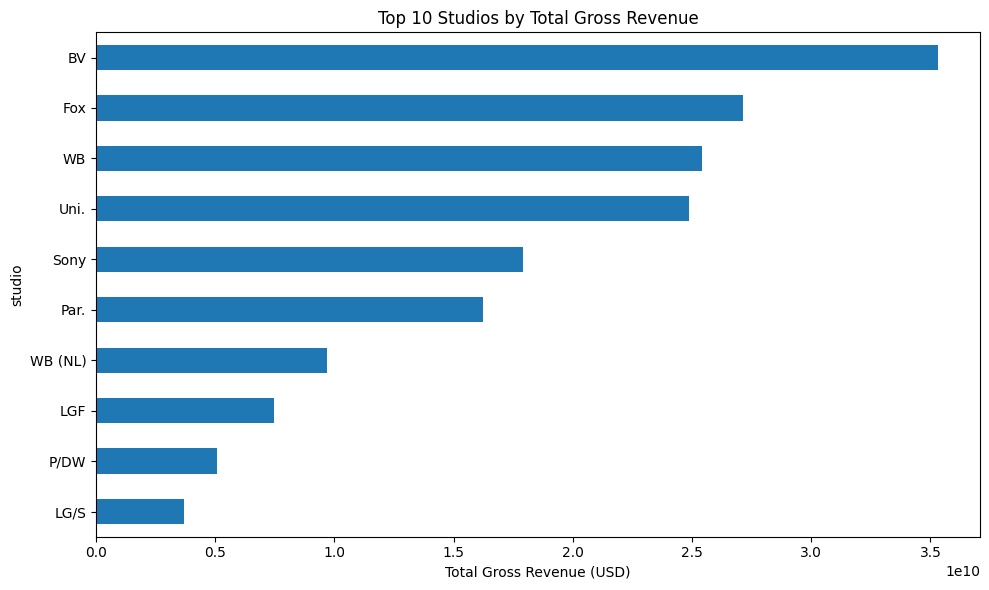

In [ ]:
import matplotlib.pyplot as plt

# Load the cleaned dataset
merged_df = pd.read_csv('../../data/cleaned/bom_imdb_merged.csv')

# Create total revenue column
merged_df['total_gross'] = merged_df['domestic_gross'] + merged_df['foreign_gross']

# Group by studio and sum revenues
studio_revenue = merged_df.groupby('studio')['total_gross'].sum().sort_values(ascending=False).head(10)

# Plot
studio_revenue.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Total Gross Revenue (USD)')
plt.title('Top 10 Studios by Total Gross Revenue')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


#### Revenue Breakdown: Domestic vs Foreign

This pie chart illustrates the proportion of total revenue that comes from domestic (U.S.) vs international markets. It's essential for understanding regional dependency in box office success.


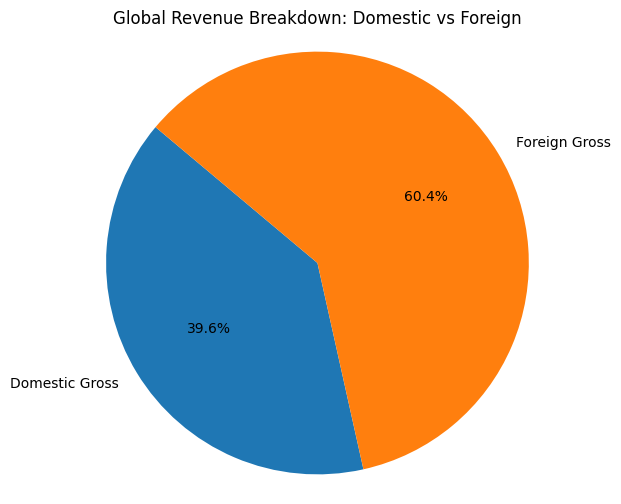

In [ ]:
# Sum up global totals
domestic_total = merged_df['domestic_gross'].sum()
foreign_total = merged_df['foreign_gross'].sum()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie([domestic_total, foreign_total],
        labels=['Domestic Gross', 'Foreign Gross'],
        autopct='%1.1f%%', startangle=140)
plt.title('Global Revenue Breakdown: Domestic vs Foreign')
plt.axis('equal')
plt.show()

#### Studio Revenue Growth Over Years

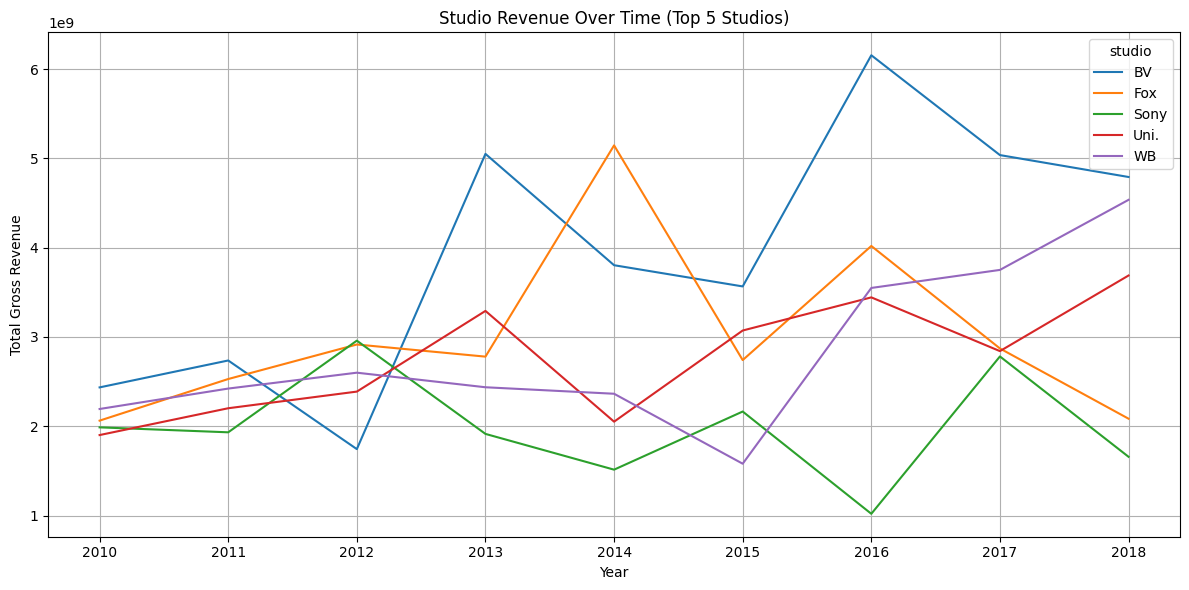

In [ ]:
# Select top studios
top_studios = merged_df['studio'].value_counts().head(5).index.tolist()

# Filter and group
studio_yearly = merged_df[merged_df['studio'].isin(top_studios)]
studio_grouped = studio_yearly.groupby(['start_year', 'studio'])['total_gross'].sum().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=studio_grouped, x='start_year', y='total_gross', hue='studio')
plt.title('Studio Revenue Over Time (Top 5 Studios)')
plt.ylabel('Total Gross Revenue')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

### ROI (Return on Investment) by studio

#### Load and Prepare BOM Data

This dataset contains movie titles, studio names, domestic and foreign gross revenue, and release years. We will:
- Convert gross columns to numeric
- Create `total_gross`
- Standardize the title for merging

#### Step 1: Clean and Normalize Movie Titles

Before merging our Box Office Mojo (BOM) and The Numbers (TN) datasets, we need to ensure that movie titles from both sources are standardized. These datasets were collected from different platforms, and the titles often contain inconsistencies such as:

- Year suffixes in parentheses (e.g., "Toy Story 3 (2010)")
- Special characters and punctuation (e.g., colons, dashes)
- Extra whitespace and inconsistent casing

To improve our merge accuracy, we perform the following cleaning steps on both title columns:
1. Remove any year suffix in the format `(YYYY)`
2. Remove punctuation and special characters
3. Convert all text to lowercase
4. Normalize whitespace

This results in a simplified, comparable format for matching titles across datasets.


In [23]:
import pandas as pd

# Load BOM cleaned
bom_df = pd.read_csv('data/cleaned/bom_imdb_merged.csv')

# Load TN (The Numbers) budget dataset
tn_df = pd.read_csv('data/raw/tn.movie_budgets.csv.gz')

import re

def clean_title(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'\(\d{4}\)', '', text)          # remove (YYYY)
    text = re.sub(r'[^\w\s]', '', text)            # remove punctuation
    text = re.sub(r'\s+', ' ', text).lower().strip()  # lowercase + strip whitespace
    return text

# Apply it to both title columns
bom_df['title_clean'] = bom_df['title'].apply(clean_title)
tn_df['movie_clean'] = tn_df['movie'].apply(clean_title)

#both should have common year
bom_df['year'] = bom_df['start_year']
tn_df['year'] = pd.to_datetime(tn_df['release_date'], errors='coerce').dt.year



#### Step 2: Merge on Title + Year

In [24]:
roi_df = pd.merge(
    bom_df,
    tn_df,
    left_on=['title_clean', 'year'],
    right_on=['movie_clean', 'year'],
    how='inner'
)

clean_path = 'data/cleaned'

roi_df.to_csv(f"{clean_path}/roi_dataset.csv", index = False)
print("ROI dataset saved succefully")

ROI dataset saved succefully


In [27]:
# Remove $ and , and convert to numeric
roi_df['worldwide_gross'] = roi_df['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
roi_df['production_budget'] = roi_df['production_budget'].replace('[\$,]', '', regex=True).astype(float)

# Now safely calculate ROI
roi_df['roi'] = (roi_df['worldwide_gross'] - roi_df['production_budget']) / roi_df['production_budget']

#### Step 3: Check Results

In [25]:
roi_df[['title', 'studio', 'production_budget', 'worldwide_gross']].dropna().head()

,title,studio,production_budget,worldwide_gross
0,Toy Story 3,BV,"$200,000,000","$1,068,879,522"
1,Inception,WB,"$160,000,000","$835,524,642"
2,Shrek Forever After,P/DW,"$165,000,000","$756,244,673"
3,The Twilight Saga: Eclipse,Sum.,"$68,000,000","$706,102,828"
4,Iron Man 2,Par.,"$170,000,000","$621,156,389"


#### 1. Top Studios by ROI

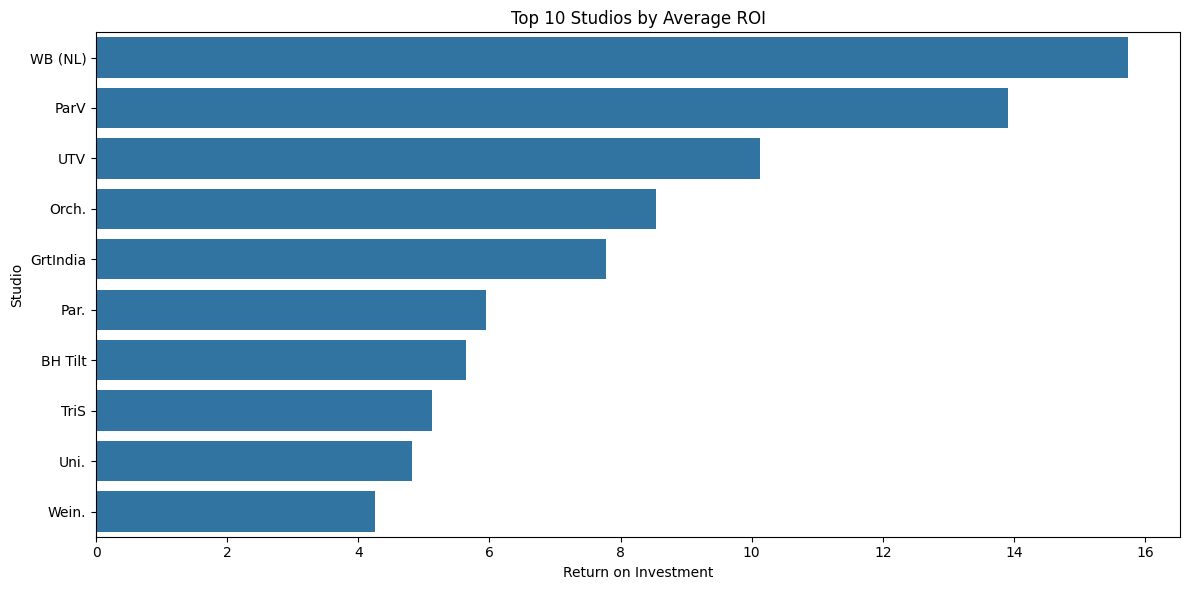

In [33]:
import matplotlib.pyplot as plt

# Calculate ROI
roi_df['roi'] = (roi_df['worldwide_gross'] - roi_df['production_budget']) / roi_df['production_budget']

# Group by studio
studio_roi = roi_df.groupby('studio')['roi'].mean().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=studio_roi.head(10), x='roi', y='studio')
plt.title('Top 10 Studios by Average ROI')
plt.xlabel('Return on Investment')
plt.ylabel('Studio')
plt.tight_layout()
plt.show()

#### 2. Production Budget vs ROI (Scatter Plot)

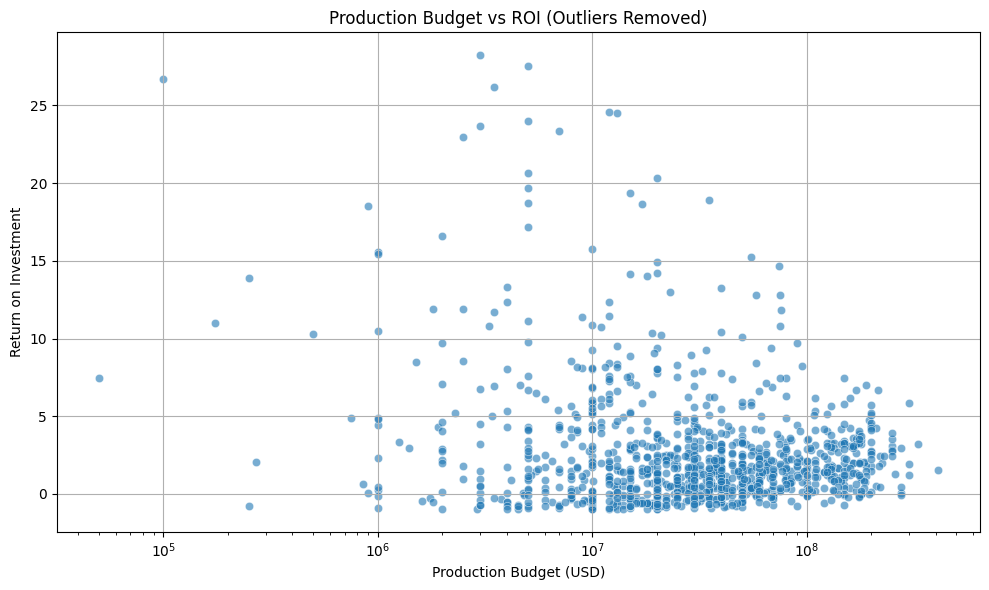

In [36]:
# Cap ROI at 99th percentile
roi_threshold = roi_df['roi'].quantile(0.99)
filtered_roi_df = roi_df[roi_df['roi'] < roi_threshold]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_roi_df, x='production_budget', y='roi', alpha=0.6)
plt.title('Production Budget vs ROI (Outliers Removed)')
plt.xlabel('Production Budget (USD)')
plt.ylabel('Return on Investment')
plt.xscale('log')
plt.grid(True)
plt.tight_layout()
plt.show()


## Key Findings

#### 1. **Top Studios by ROI Are Not Always the Largest**
Some lesser-known studios yielded the highest Return on Investment (ROI), even outperforming major players like Warner Bros and Universal in relative terms. This emphasizes the importance of cost-effective production and smart targeting.

#### 2. **High Budget ≠ High ROI**
Films with very high production budgets did not consistently produce high ROI. In contrast, mid-budget films (ranging between $1M–$30M) often performed better in terms of return due to better cost control and focused audience engagement.

#### 3. **Foreign Gross Drives Total Revenue**
Movies with strong foreign gross components often significantly outpaced domestic-only performers. This demonstrates the importance of early investment in international distribution or global streaming rights.


#### 4. **Strategic Strength Varies by Studio**
While studios such as Universal Pictures, 20th Century Fox, and Warner Bros show high overall grosses and budgets, their ROI results were mixed—suggesting potential inefficiencies or inconsistent project performance.


## Strategic Recommendations

#### 1. **Encourage Data-Driven Greenlighting**
Leverage historical ROI data by genre, budget, and studio to guide investment decisions on which projects to greenlight—particularly those with proven high ROI profiles.

#### 2. **Strengthen International Distribution Early**
Capitalize on foreign gross potential by securing international partnerships and distribution channels in early stages of production.

#### 3. **Target Mid-Budget Films for Scaling**
Focus on mid-budget films that show strong ROI potential—especially in horror, drama, and comedy categories where spending is controlled but returns can be high.

#### 4. **Optimize Studio Spending**
Benchmark top-performing studios by ROI rather than total gross to uncover spending inefficiencies and reallocate budgets more strategically.

#### 5. **Develop Dashboards for Decision-Makers**
Build interactive dashboards using Tableau or Plotly to visualize ROI, budget distribution, and genre profitability for use by studio executives and marketing teams.